In [14]:
# %%
import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# %%
# Load JSON data
with open('user-wallet-transactions.json') as f:
    data = json.load(f)
    
df = pd.DataFrame(data)
print(f"Loaded {len(df)} transactions from {df['userWallet'].nunique()} unique wallets")

Loaded 100000 transactions from 3497 unique wallets


In [18]:
# %%
# Extract nested fields and clean data
df['asset'] = df['actionData'].apply(lambda x: x.get('assetSymbol'))
df['amount'] = df['actionData'].apply(lambda x: float(x.get('amount', 0)))
# FIX: Add utc=True to make the timestamp column timezone-aware
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True)

# Show sample data
df[['userWallet', 'action', 'asset', 'amount', 'timestamp']].head()

,userWallet,action,asset,amount,timestamp
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,deposit,USDC,2.000000e+09,2021-08-17 05:29:26+00:00
1,0x000000000051d07a4fb3bd10121a343d85818da6,deposit,WMATIC,1.450000e+20,2021-05-20 15:36:53+00:00
2,0x000000000096026fb41fc39f9875d164bd82e2dc,deposit,WMATIC,1.000000e+15,2021-07-24 09:28:33+00:00
3,0x000000000096026fb41fc39f9875d164bd82e2dc,deposit,WMATIC,4.000000e+15,2021-07-31 23:15:18+00:00
4,0x0000000000e189dd664b9ab08a33c4839953852c,redeemunderlying,USDC,5.015480e+05,2021-04-19 15:25:07+00:00


In [19]:
# %%
# Transaction frequency and recency features
tx_freq = df.groupby('userWallet')['timestamp'].agg(
    first_tx='min',
    last_tx='max',
    tx_count='count'
).reset_index()

# Calculate transaction frequency (transactions per day)
# .clip(lower=86400) prevents division by zero for single-transaction wallets
tx_freq['tx_freq_per_day'] = tx_freq['tx_count'] / (
    (tx_freq['last_tx'] - tx_freq['first_tx']).dt.total_seconds().clip(lower=86400) / 86400
)

# Calculate how many days have passed since the last transaction
tx_freq['days_since_last_tx'] = (pd.to_datetime('now', utc=True) - tx_freq['last_tx']).dt.days

print("Transaction Frequency Features:")
tx_freq.head()

Transaction Frequency Features:


,userWallet,first_tx,last_tx,tx_count,tx_freq_per_day,days_since_last_tx
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,2021-08-17 05:29:26+00:00,2021-08-17 05:29:26+00:00,1,1.000000,1431
1,0x000000000051d07a4fb3bd10121a343d85818da6,2021-05-20 15:36:53+00:00,2021-05-20 15:36:53+00:00,1,1.000000,1520
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2021-07-24 09:28:33+00:00,2021-07-31 23:15:18+00:00,2,0.264057,1447
3,0x0000000000e189dd664b9ab08a33c4839953852c,2021-04-19 15:23:17+00:00,2021-08-26 23:15:16+00:00,17,0.131449,1421
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,2021-04-21 21:28:30+00:00,2021-09-01 18:15:24+00:00,399,3.003028,1415


In [20]:
# %%
# Asset diversity features
asset_div = df.groupby('userWallet')['asset'].nunique().reset_index(name='unique_assets')

print("\nAsset Diversity Features:")
asset_div.head()


Asset Diversity Features:


,userWallet,unique_assets
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1
1,0x000000000051d07a4fb3bd10121a343d85818da6,1
2,0x000000000096026fb41fc39f9875d164bd82e2dc,1
3,0x0000000000e189dd664b9ab08a33c4839953852c,4
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,6


In [21]:
# %%
# Behavior pattern features (deposits, borrows, etc.)
def get_action_stats(df, action):
    action_df = df[df['action'] == action]
    if action_df.empty:
        return pd.DataFrame(columns=['userWallet', f'{action}_amount_sum', f'{action}_amount_avg'])
    
    return action_df.groupby('userWallet').agg(
        amount_sum=('amount', 'sum'),
        amount_avg=('amount', 'mean')
    ).add_prefix(f'{action}_').reset_index()

deposit_stats = get_action_stats(df, 'deposit')
withdraw_stats = get_action_stats(df, 'redeemunderlying')
borrow_stats = get_action_stats(df, 'borrow')
repay_stats = get_action_stats(df, 'repay')

print("\nSample Deposit Stats:")
deposit_stats.head()


Sample Deposit Stats:


,userWallet,deposit_amount_sum,deposit_amount_avg
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,2.000000e+09,2.000000e+09
1,0x000000000051d07a4fb3bd10121a343d85818da6,1.450000e+20,1.450000e+20
2,0x000000000096026fb41fc39f9875d164bd82e2dc,5.000000e+15,2.500000e+15
3,0x0000000002032370b971dabd36d72f3e5a7bf1ee,9.459366e+22,3.783746e+20
4,0x000000000a38444e0a6e37d3b630d7e855a7cb13,1.060962e+22,1.515660e+21


In [22]:
# %%
# Liquidation features
liquidations = df[df['action'] == 'liquidationcall'].groupby('userWallet').size().reset_index(name='liquidation_count')

print("\nLiquidation Features:")
liquidations.head()


Liquidation Features:


,userWallet,liquidation_count
0,0x000006eee6e39015cb523aebdd4d0b1855aba682,3
1,0x00129c4ce6be31b273de64c65ff3fcdd4706a002,2
2,0x0037daf6fb154db55110ced85cb4ba9e1204ca17,1
3,0x003be39433bde975b12411fbc3025d49d813a84f,3
4,0x004afb002e3fb33c833fc16b6b63103bbf97312d,1


In [23]:
# %%
# Combine all features into a single DataFrame
features = tx_freq.merge(asset_div, on='userWallet', how='left') \
    .merge(deposit_stats, on='userWallet', how='left') \
    .merge(withdraw_stats, on='userWallet', how='left') \
    .merge(borrow_stats, on='userWallet', how='left') \
    .merge(repay_stats, on='userWallet', how='left') \
    .merge(liquidations, on='userWallet', how='left')

# Calculate financial ratios
# Deposit Ratio: How much of the total deposited amount has been withdrawn?
features['deposit_ratio'] = (features['redeemunderlying_amount_sum'] / features['deposit_amount_sum']).replace([np.inf, -np.inf], 0)
# Borrow Ratio: How much of the total borrowed amount has been repaid?
features['borrow_ratio'] = (features['repay_amount_sum'] / features['borrow_amount_sum']).replace([np.inf, -np.inf], 0)

# Fill NA values with 0 for wallets that didn't perform certain actions
features.fillna(0, inplace=True)

print("\nFinal Combined Features:")
features.head()


Final Combined Features:


,userWallet,first_tx,last_tx,tx_count,tx_freq_per_day,days_since_last_tx,unique_assets,deposit_amount_sum,deposit_amount_avg,redeemunderlying_amount_sum,redeemunderlying_amount_avg,borrow_amount_sum,borrow_amount_avg,repay_amount_sum,repay_amount_avg,liquidation_count,deposit_ratio,borrow_ratio
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,2021-08-17 05:29:26+00:00,2021-08-17 05:29:26+00:00,1,1.000000,1431,1,2.000000e+09,2.000000e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000e+00
1,0x000000000051d07a4fb3bd10121a343d85818da6,2021-05-20 15:36:53+00:00,2021-05-20 15:36:53+00:00,1,1.000000,1520,1,1.450000e+20,1.450000e+20,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000e+00
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2021-07-24 09:28:33+00:00,2021-07-31 23:15:18+00:00,2,0.264057,1447,1,5.000000e+15,2.500000e+15,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000e+00
3,0x0000000000e189dd664b9ab08a33c4839953852c,2021-04-19 15:23:17+00:00,2021-08-26 23:15:16+00:00,17,0.131449,1421,4,0.000000e+00,0.000000e+00,4.835297e+18,2.844292e+17,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000e+00
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,2021-04-21 21:28:30+00:00,2021-09-01 18:15:24+00:00,399,3.003028,1415,6,9.459366e+22,3.783746e+20,3.946556e+22,3.035812e+20,3.946000e+22,2.630667e+21,7.002457e+10,1.750614e+10,0.0,0.417211,1.774571e-12


In [24]:
# %%
# Define weights for each feature to calculate the credit score
# Positive weights reward good behavior, negative weights penalize risky behavior.
weights = {
    'tx_count': 0.15,               # Higher activity is generally positive
    'tx_freq_per_day': 0.1,         # Frequent, consistent activity
    'unique_assets': 0.1,           # Diversification can indicate sophistication
    'deposit_amount_sum': 0.15,     # Larger deposits indicate higher capacity
    'deposit_ratio': -0.1,          # A high ratio (withdrawing a lot) is slightly negative
    'borrow_ratio': 0.2,            # A high repayment ratio is a strong positive signal
    'days_since_last_tx': -0.05,    # Inactivity is a slight negative
    'liquidation_count': -0.25      # Liquidations are a strong negative signal
}

In [25]:
# %%
# Normalize features to a 0-1 scale
scaler = MinMaxScaler()
feature_cols = list(weights.keys())

# Ensure all feature columns exist before scaling
for col in feature_cols:
    if col not in features.columns:
        features[col] = 0

features[feature_cols] = scaler.fit_transform(features[feature_cols])

# Calculate raw weighted score
features['raw_score'] = 0
for feature, weight in weights.items():
    features['raw_score'] += features[feature] * weight

In [26]:
# %%
# Use Isolation Forest to detect anomalous (potentially bot-like or malicious) behavior
iso = IsolationForest(contamination=0.05, random_state=42)
features['is_anomaly'] = iso.fit_predict(features[feature_cols]) == -1

# Scale raw score to 0-1000 range and apply penalty for anomalies
min_raw_score = features['raw_score'].min()
max_raw_score = features['raw_score'].max()
features['credit_score'] = (
    (features['raw_score'] - min_raw_score) / (max_raw_score - min_raw_score) * 1000
).astype(int)

# Reduce the score for wallets flagged as anomalies
features.loc[features['is_anomaly'], 'credit_score'] = (features.loc[features['is_anomaly'], 'credit_score'] * 0.5).astype(int)

In [27]:
# %%
# Get final scores and sort by the highest
final_scores = features[['userWallet', 'credit_score']].sort_values('credit_score', ascending=False)

# Show top 10 wallets
print("Top 10 Wallets by Credit Score:")
final_scores.head(10)

Top 10 Wallets by Credit Score:


,userWallet,credit_score
207,0x0051e6e6cde6392c01b4cf6b97d9f5c50ec9817c,1000
660,0x010da4bb5ed14c387bc92de075b58e2d0cee23b1,960
1058,0x01b92f893b1c302bcf1945fd4edf10df99b4f181,884
2940,0x0520e146a8eb11276ae1b4afdb9ab02bdb27b831,883
1790,0x030888e8fe9f0cbe3ff04c0fda1c0954c6b68822,874
2846,0x04efc3225aa96a0fcb977bfbada6712f99310545,867
1715,0x02e4ac7c366cf7320bc78b816b162b26d605a4bd,861
75,0x0019971fb18fbfc9108d90eb2cdd4d5a0a897eee,856
2722,0x04bdfb9f9704694ca365b8e27bbdb7e093475340,854
1389,0x025297ca7459dd67dbfd8443d9b5f321e89fad83,833


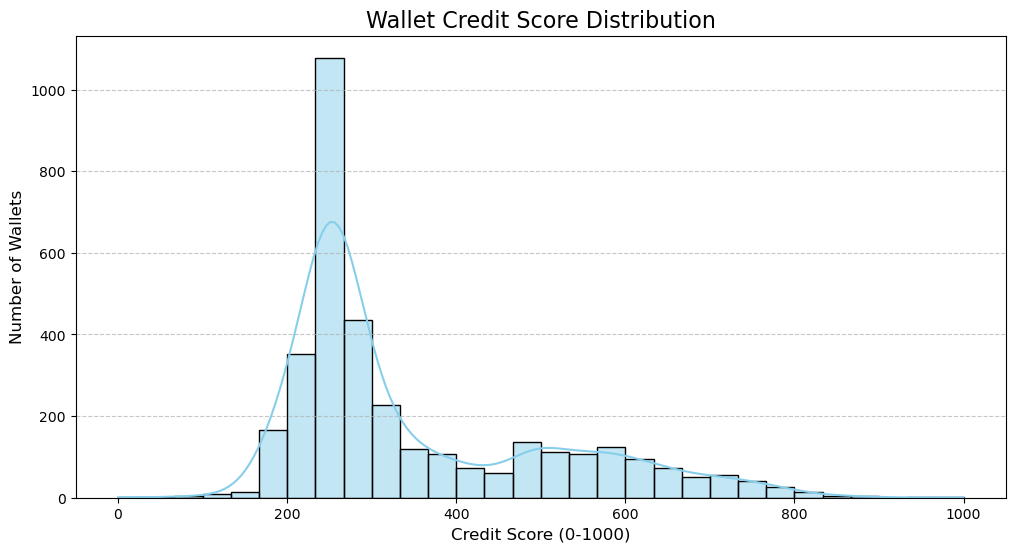

In [28]:
# %%
# Plot the distribution of credit scores
plt.figure(figsize=(12, 6))
sns.histplot(final_scores['credit_score'], bins=30, kde=True, color='skyblue')
plt.title('Wallet Credit Score Distribution', fontsize=16)
plt.xlabel('Credit Score (0-1000)', fontsize=12)
plt.ylabel('Number of Wallets', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [29]:
# %%
# Save the final scores to a CSV file
final_scores.to_csv('aave_credit_scores.csv', index=False)
print("✅ Results saved to 'aave_credit_scores.csv'")

✅ Results saved to 'aave_credit_scores.csv'
